In [123]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import matplotlib.pyplot as plt

In [124]:
n = 1000
phi1 = 0.2
phi2 = 0.4
sigma_s = 1

Zadanie 1

In [145]:
def autokowariancja(h, x):
    n = len(x)
    mean_x = np.mean(x)
    return 1/n * np.sum((x[:n-abs(h)] - mean_x) * (x[abs(h):] - mean_x))

In [146]:
def estim_phi_sigma_s(trajectory, p):
    ps = np.arange(1,p+1,1)
    emp_autokow = np.transpose([autokowariancja(p_, trajectory) for p_ in ps])
    gamma_dash = np.zeros((p,p))
    for i in range(p):
        for j in range(p):
            gamma_dash[i][j] = autokowariancja(i - j, trajectory)
    phi_dash = np.linalg.inv(gamma_dash) @ emp_autokow
    sigma_s_dash = autokowariancja(0, trajectory) - np.transpose(phi_dash) @ emp_autokow
    return phi_dash, sigma_s_dash

In [147]:
mc = 1000
phi1s = []
phi2s = []
sigmas = []
for _ in range(mc):
    ar_process = ArmaProcess(ar = [1, -phi1, -phi2], ma = [1])
    trajectory = ar_process.generate_sample(nsample=n)
    phis, sigma_s = estim_phi_sigma_s(trajectory, 2)
    phi1s.append(phis[0])
    phi2s.append(phis[1])
    sigmas.append(sigma_s)

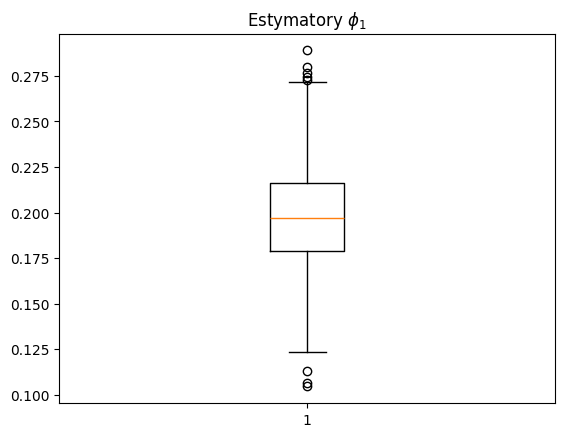

In [148]:
plt.boxplot(phi1s)
plt.title("Estymatory $\\phi_1$")
plt.show()

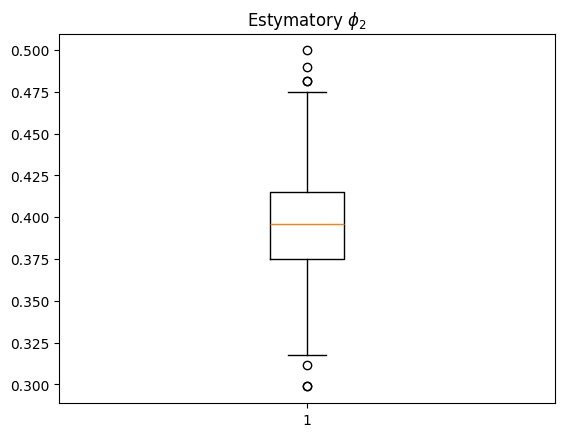

In [149]:
plt.boxplot(phi2s)
plt.title("Estymatory $\\phi_2$")
plt.show()

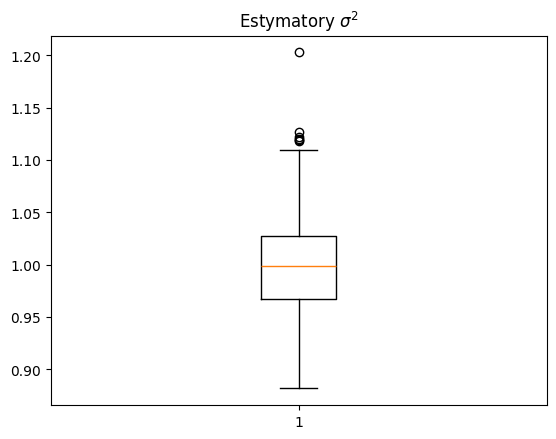

In [152]:
plt.boxplot(sigmas)
plt.title("Estymatory $\\sigma^2$")
plt.show()

Zadanie 4

In [126]:
ar_process = ArmaProcess(ar = [1, -phi1, -phi2], ma = [1])
trajectory = ar_process.generate_sample(nsample=n)

In [127]:
def autokowariancja(h, x):
    n = len(x)
    mean_x = np.mean(x)
    return 1/n * np.sum((x[:n-abs(h)] - mean_x) * (x[abs(h):] - mean_x))

In [128]:
hs = np.arange(0,11,1)
emp_autokow = [autokowariancja(h, trajectory) for h in hs]

In [129]:
def teo_autokow(h,phi1, phi2, sigma_s):
    zero = sigma_s**2 * (1-phi2) / (1- phi2 - phi1**2 - phi1**2*phi2 - phi2**2 + phi2**3)
    if h == 0:
        return zero
    elif h == 1:
        return phi1 / (1 - phi2) * zero
    else:
        return teo_autokow(h - 1, phi1, phi2, sigma_s) * phi1 + teo_autokow(h-2, phi1, phi2, sigma_s) * phi2

In [130]:
teo = []
for h in hs:
    teo.append(teo_autokow(h, phi1, phi2, sigma_s))

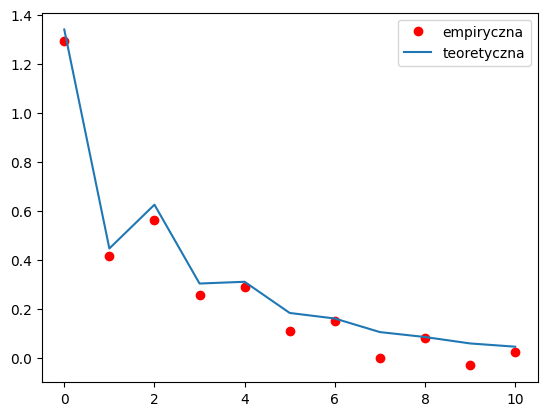

In [131]:
plt.plot(hs, emp_autokow, "ro", label="empiryczna")
plt.plot(hs, teo, label="teoretyczna")
plt.legend(loc="best")
plt.show()